In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=72340bed1abc0bd07e1e8792447aad7c874870edadcad8ecde27d16bd67afd1c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
class AirQualityDataProcessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def load_datasets(self, base_path=""):
        """
        Load all datasets from specified path
        """
        # Load geolocation data
        geo_data = pd.read_csv(f"{base_path}Jinja_2023_site_geolocation.csv")

        # Load main air quality dataset
        air_quality = pd.read_csv(f"{base_path}Jinja_2023_sites_dataset.csv")
        air_quality['timestamp'] = pd.to_datetime(air_quality['timestamp'])

        # Load population density datasets
        pop_density = pd.read_csv(f"{base_path}Jinja_pd_km2_2023.csv")
        un_pop_density = pd.read_csv(f"{base_path}Jinja_UN_pd_km2_2023.csv")

        # Load infrastructure datasets
        infra_250m = pd.read_csv(f"{base_path}Jinja_road_and_building_data_250m_2023.csv")
        infra_500m = pd.read_csv(f"{base_path}Jinja_road_and_building_data_500m_2023.csv")

        return {
            'geo': geo_data,
            'air_quality': air_quality,
            'pop_density': pop_density,
            'un_pop_density': un_pop_density,
            'infra_250m': infra_250m,
            'infra_500m': infra_500m
        }

    def merge_datasets(self, datasets):
        """
        Merge all datasets based on site_id and timestamp
        """
        # Start with air quality data as the base
        merged_data = datasets['air_quality'].copy()

        # Add population density features
        pop_density_features = pd.merge(
            datasets['pop_density'][['site_id', 'population_density']],
            datasets['un_pop_density'][['site_id', 'population_density']],
            on='site_id',
            suffixes=('_local', '_un')
        )
        merged_data = pd.merge(merged_data, pop_density_features, on='site_id')

        # Add infrastructure features
        infra_features = []
        for radius in ['250m', '500m']:
            infra_data = datasets[f'infra_{radius}'].copy()
            # Rename columns to include radius
            infra_data.columns = [
                f"{col}_{radius}" if col not in ['site_id', 'site_name', 'site_latitude', 'site_longitude']
                else col for col in infra_data.columns
            ]
            infra_features.append(infra_data)

        # Merge infrastructure features
        for infra_data in infra_features:
            merged_data = pd.merge(merged_data, infra_data, on='site_id')

        return merged_data

    def engineer_features(self, df):
        """
        Create additional features that might be useful for prediction
        """
        # Time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

        # Weather interaction features
        df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
        df['wind_effective'] = df['wind_speed'] * np.cos(np.radians(df['wind_direction']))

        # Infrastructure density ratios
        df['building_road_ratio_250m'] = (
            df['building_density_250m'] / df['road_density_250m'].replace(0, np.nan)
        ).fillna(0)
        df['building_road_ratio_500m'] = (
            df['building_density_500m'] / df['road_density_500m'].replace(0, np.nan)
        ).fillna(0)

        return df

    def prepare_for_training(self, df, target_col='pm2_5_calibrated_value'):
        """
        Prepare final dataset for model training
        """
        # Drop unnecessary columns
        cols_to_drop = [
            'Unnamed: 0', 'site_name', 'site_latitude', 'site_longitude',
            'city', 'country', 'timestamp', 'pm10_raw_value',
            'pm10_calibrated_value','pm2_5_raw_value'
        ]
        df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)

        # Handle missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

        # Scale features (excluding target)
        feature_cols = [col for col in numeric_cols if col != target_col]
        df[feature_cols] = self.scaler.fit_transform(df[feature_cols])

        # Prepare X and y
        X = df[feature_cols]
        y = df[target_col]

        return X, y

    def process_data(self, base_path=""):
        """
        Run the complete data processing pipeline
        """
        # Load all datasets
        datasets = self.load_datasets(base_path)

        # Merge datasets
        merged_data = self.merge_datasets(datasets)

        # Engineer features
        featured_data = self.engineer_features(merged_data)

        # Prepare for training
        X, y = self.prepare_for_training(featured_data)

        return X, y, featured_data

In [ ]:
class AirQualityModelPipeline:
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.models = {}
        self.best_model = None
        self.feature_importance = None
        self.cv_results = {}

    def initialize_models(self):
        """
        Initialize multiple models for comparison
        """
        self.models = {
            'rf': RandomForestRegressor(random_state=self.random_state),
            'gbm': GradientBoostingRegressor(random_state=self.random_state),
            'xgb': XGBRegressor(random_state=self.random_state),
            'lgbm': LGBMRegressor(random_state=self.random_state),
            'lasso': LassoCV(random_state=self.random_state)
        }

    def objective_rf(self, trial, X, y):
        """
        Objective function for Random Forest optimization
        """
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
        }

        model = RandomForestRegressor(**params, random_state=self.random_state)
        scores = cross_val_score(model, X, y, cv=TimeSeriesSplit(n_splits=self.n_splits),
                               scoring='neg_root_mean_squared_error')
        return -scores.mean()

    def objective_xgb(self, trial, X, y):
        """
        Objective function for XGBoost optimization
        """
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7)
        }

        model = XGBRegressor(**params, random_state=self.random_state)
        scores = cross_val_score(model, X, y, cv=TimeSeriesSplit(n_splits=self.n_splits),
                               scoring='neg_root_mean_squared_error')
        return -scores.mean()

    def optimize_hyperparameters(self, X, y, n_trials=100):
        """
        Optimize hyperparameters using Optuna for multiple models
        """
        optimized_models = {}

        # Random Forest optimization
        study_rf = optuna.create_study(direction='minimize')
        study_rf.optimize(lambda trial: self.objective_rf(trial, X, y), n_trials=n_trials)
        optimized_models['rf'] = RandomForestRegressor(**study_rf.best_params,
                                                     random_state=self.random_state)

        # XGBoost optimization
        study_xgb = optuna.create_study(direction='minimize')
        study_xgb.optimize(lambda trial: self.objective_xgb(trial, X, y), n_trials=n_trials)
        optimized_models['xgb'] = XGBRegressor(**study_xgb.best_params,
                                             random_state=self.random_state)

        return optimized_models

    def evaluate_models(self, X, y, optimized_models):
        """
        Evaluate all models using time series cross-validation
        """
        results = {}
        tscv = TimeSeriesSplit(n_splits=self.n_splits)

        for name, model in {**self.models, **optimized_models}.items():
            cv_scores = {
                'rmse': [],
                'mae': [],
                'r2': []
            }

            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)

                cv_scores['rmse'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
                cv_scores['mae'].append(mean_absolute_error(y_val, y_pred))
                cv_scores['r2'].append(r2_score(y_val, y_pred))

            results[name] = {
                'rmse_mean': np.mean(cv_scores['rmse']),
                'rmse_std': np.std(cv_scores['rmse']),
                'mae_mean': np.mean(cv_scores['mae']),
                'mae_std': np.std(cv_scores['mae']),
                'r2_mean': np.mean(cv_scores['r2']),
                'r2_std': np.std(cv_scores['r2'])
            }

        self.cv_results = results
        return results

    def select_best_model(self, X, y, results):
        """
        Select the best model based on RMSE
        """
        best_model_name = min(results.items(), key=lambda x: x[1]['rmse_mean'])[0]
        if best_model_name in self.models:
            self.best_model = self.models[best_model_name]
        else:
            self.best_model = self.optimized_models[best_model_name]

        # Fit the best model on all data
        self.best_model.fit(X, y)

        # Calculate feature importance if available
        if hasattr(self.best_model, 'feature_importances_'):
            self.feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': self.best_model.feature_importances_
            }).sort_values('importance', ascending=False)

    def plot_feature_importance(self, top_n=20):
        """
        Plot feature importance for the best model
        """
        if self.feature_importance is not None:
            plt.figure(figsize=(12, 8))
            sns.barplot(data=self.feature_importance.head(top_n),
                       x='importance', y='feature')
            plt.title('Top Feature Importance')
            plt.tight_layout()
            plt.show()

    def save_model(self, filepath):
        """
        Save the best model and feature importance
        """
        if self.best_model is not None:
            model_info = {
                'model': self.best_model,
                'feature_importance': self.feature_importance,
                'cv_results': self.cv_results,
                'timestamp': datetime.now()
            }
            joblib.dump(model_info, filepath)

    def train(self, X, y, n_trials=100):
        """
        Run the complete training pipeline
        """
        # Initialize base models
        self.initialize_models()

        # Optimize hyperparameters
        print("Optimizing hyperparameters...")
        self.optimized_models = self.optimize_hyperparameters(X, y, n_trials)

        # Evaluate all models
        print("Evaluating models...")
        results = self.evaluate_models(X, y, self.optimized_models)

        # Select and train best model
        print("Selecting best model...")
        self.select_best_model(X, y, results)

        return results

In [ ]:
# Initialize the processor
processor = AirQualityDataProcessor()

# Process the data
X, y, full_dataset = processor.process_data("/content/drive/MyDrive/MSCS_machine_learning/Air_Quality/Data/")

In [ ]:
# Initialize and run the model pipeline
model_pipeline = AirQualityModelPipeline(n_splits=5)
results = model_pipeline.train(X, y, n_trials=5)

[I 2024-12-11 11:00:13,312] A new study created in memory with name: no-name-f34f302d-28dc-4c6f-b774-b435f59a58ff


Optimizing hyperparameters...


[I 2024-12-11 11:03:20,164] Trial 0 finished with value: 20.132236237002044 and parameters: {'n_estimators': 261, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 20.132236237002044.
[I 2024-12-11 11:07:01,507] Trial 1 finished with value: 20.000801803352367 and parameters: {'n_estimators': 237, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 1 with value: 20.000801803352367.
[I 2024-12-11 11:12:58,909] Trial 2 finished with value: 20.612812594494773 and parameters: {'n_estimators': 706, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 6}. Best is trial 1 with value: 20.000801803352367.
[I 2024-12-11 11:16:14,257] Trial 3 finished with value: 20.3727753284917 and parameters: {'n_estimators': 337, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 8}. Best is trial 1 with value: 20.000801803352367.
[I 2024-12-11 11:22:35,052] Trial 4 finished with value: 20.047393999301484 and parameters: {

Evaluating models...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2133
[LightGBM] [Info] Number of data points in the train set: 9788, number of used features: 45
[LightGBM] [Info] Start training from score 22.168898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2192
[LightGBM] [Info] Number of data points in the train set: 19572, number of used features: 45
[LightGBM] [Info] Start training from score 25.186604
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.337e+04, tolerance: 8.693e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1560.173025060445, tolerance: 1119.4081138333388
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1930.5339005310088, tolerance: 1119.4081138333388
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/li

Selecting best model...


In [ ]:
# View the cross-validation results
print("\nModel Evaluation Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"RMSE: {metrics['rmse_mean']:.4f} ± {metrics['rmse_std']:.4f}")
    print(f"MAE: {metrics['mae_mean']:.4f} ± {metrics['mae_std']:.4f}")
    print(f"R2: {metrics['r2_mean']:.4f} ± {metrics['r2_std']:.4f}")


Model Evaluation Results:

rf:
RMSE: 20.0008 ± 2.0159
MAE: 11.9144 ± 1.4942
R2: 0.2713 ± 0.0554

gbm:
RMSE: 19.9453 ± 2.2378
MAE: 12.0014 ± 1.4550
R2: 0.2777 ± 0.0448

xgb:
RMSE: 19.2092 ± 1.7279
MAE: 11.1207 ± 1.3577
R2: 0.3257 ± 0.0578

lgbm:
RMSE: 19.7284 ± 1.7889
MAE: 12.1984 ± 0.7917
R2: 0.2862 ± 0.0846

lasso:
RMSE: 21.6164 ± 2.1068
MAE: 13.4365 ± 0.7526
R2: 0.1485 ± 0.0531


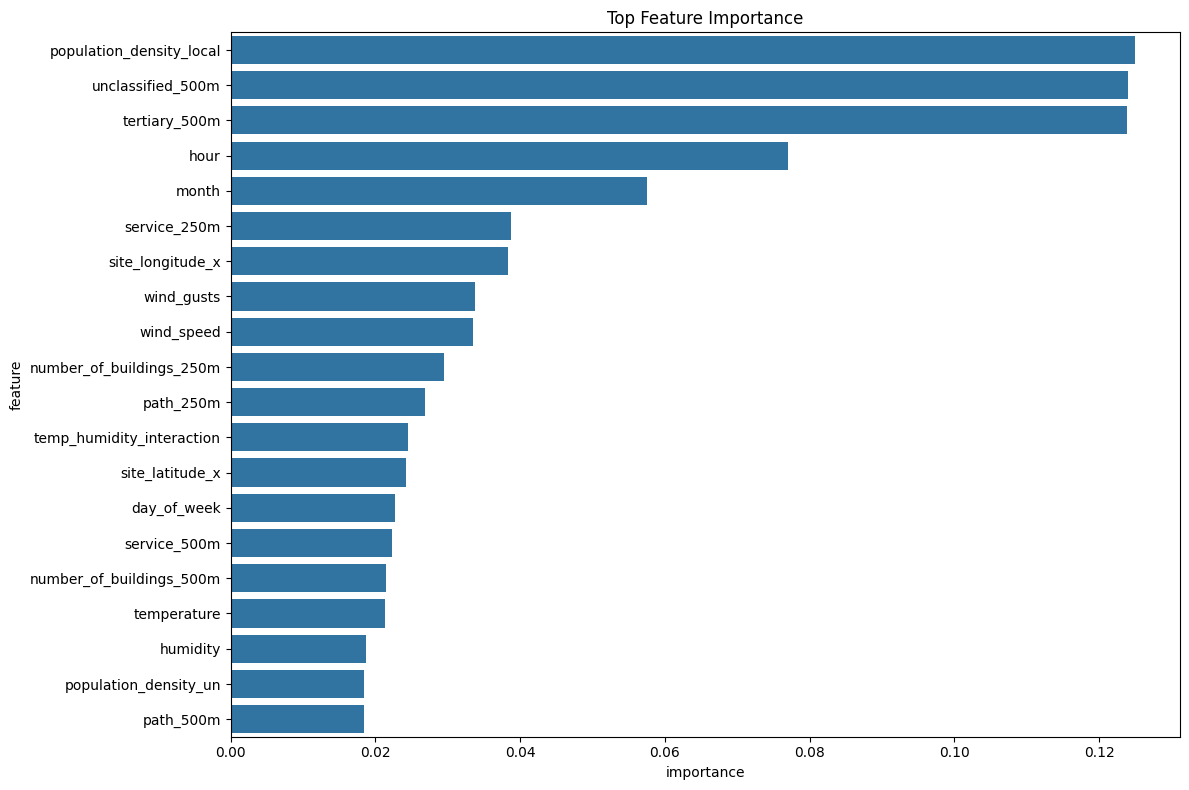

In [ ]:
# Plot feature importance
model_pipeline.plot_feature_importance()

In [ ]:
# Save the best model
model_pipeline.save_model("air_quality_model.joblib")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_model_performance_comparison(model_pipeline):
    """
    Generate a performance comparison plot for different models
    """
    # Extract model names and RMSE values
    model_names = list(model_pipeline.cv_results.keys())
    rmse_means = [results['rmse_mean'] for model_name, results in model_pipeline.cv_results.items()]
    rmse_stds = [results['rmse_std'] for model_name, results in model_pipeline.cv_results.items()]
    r2_means = [results['r2_mean'] for model_name, results in model_pipeline.cv_results.items()]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # RMSE Comparison
    ax1.bar(model_names, rmse_means, yerr=rmse_stds, capsize=10)
    ax1.set_title('Model Performance: RMSE')
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Root Mean Squared Error')
    ax1.tick_params(axis='x', rotation=45)

    # R2 Comparison
    ax2.bar(model_names, r2_means)
    ax2.set_title('Model Performance: R²')
    ax2.set_xlabel('Models')
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    return fig

def plot_predicted_vs_actual(model_pipeline, X, y):
    """
    Generate scatter plots comparing predicted and actual AQI values
    for top performing models
    """
    # Identify top 2 models based on RMSE
    sorted_models = sorted(model_pipeline.cv_results.items(), key=lambda x: x[1]['rmse_mean'])
    top_models = sorted_models[:2]

    # Create a figure with subplots for top models
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Predicted vs Actual AQI Values')

    for i, (model_name, _) in enumerate(top_models):
        # Get the actual model
        if model_name in model_pipeline.models:
            model = model_pipeline.models[model_name]
        else:
            model = model_pipeline.optimized_models[model_name]

        # Predict values
        y_pred = model.predict(X)

        # Scatter plot
        axes[i].scatter(y, y_pred, alpha=0.5)
        axes[i].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Diagonal line
        axes[i].set_title(f'{model_name.upper()} - Predicted vs Actual')
        axes[i].set_xlabel('Actual Values')
        axes[i].set_ylabel('Predicted Values')

    plt.tight_layout()
    plt.show()
    return fig

def plot_pollutant_concentration_heatmap(full_dataset):
    """
    Generate a temporal heatmap of pollutant concentrations
    """
    # Prepare data for heatmap
    temporal_data = full_dataset.copy()
    temporal_data['hour'] = temporal_data['timestamp'].dt.hour
    temporal_data['month'] = temporal_data['timestamp'].dt.month

    # Select key pollutant columns
    pollutant_cols = ['pm2_5_calibrated_value', 'pm10_calibrated_value', 'temperature', 'humidity']

    # Create a figure with subplots for each pollutant
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Pollutant Concentration Heatmap')

    for i, pollutant in enumerate(pollutant_cols):
        # Create pivot table for heatmap
        heatmap_data = temporal_data.pivot_table(
            index='month',
            columns='hour',
            values=pollutant,
            aggfunc='mean'
        )

        # Plot heatmap
        row = i // 2
        col = i % 2
        sns.heatmap(heatmap_data, ax=axes[row, col], cmap='YlOrRd',
                    cbar_kws={'label': f'{pollutant} Concentration'})
        axes[row, col].set_title(f'{pollutant} Concentration')
        axes[row, col].set_xlabel('Hour of Day')
        axes[row, col].set_ylabel('Month')

    plt.tight_layout()
    plt.show()
    return fig

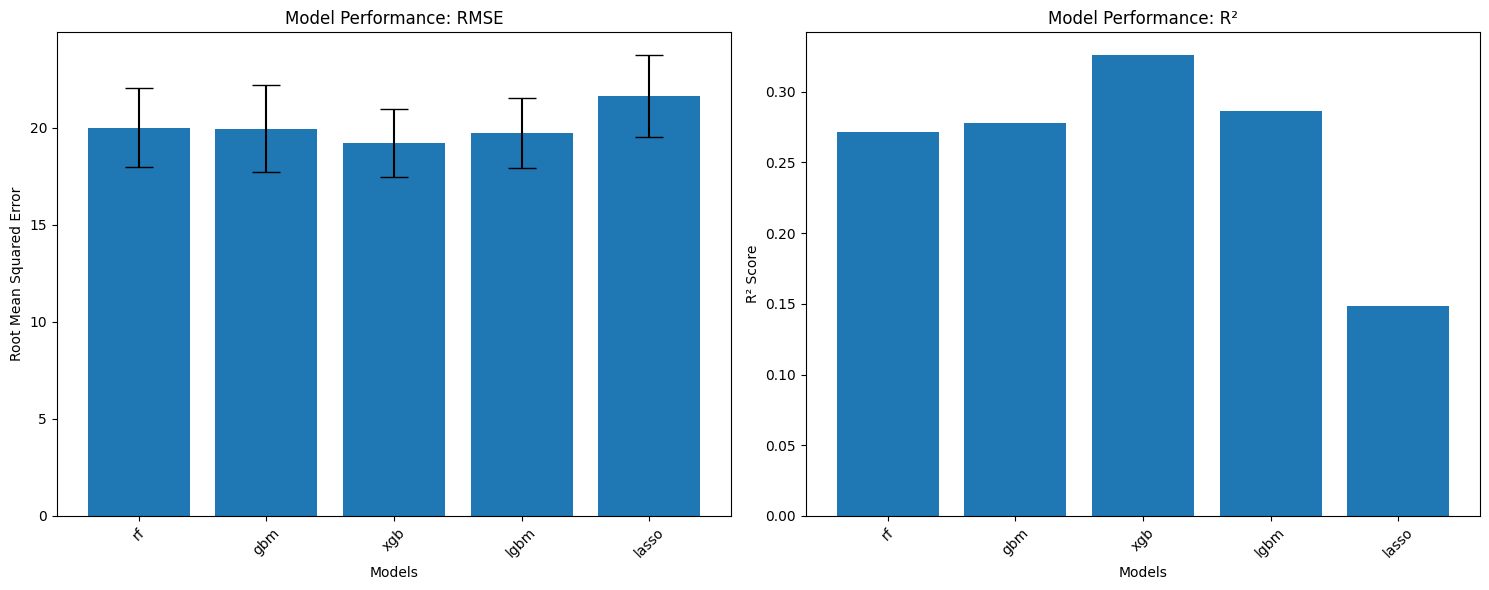

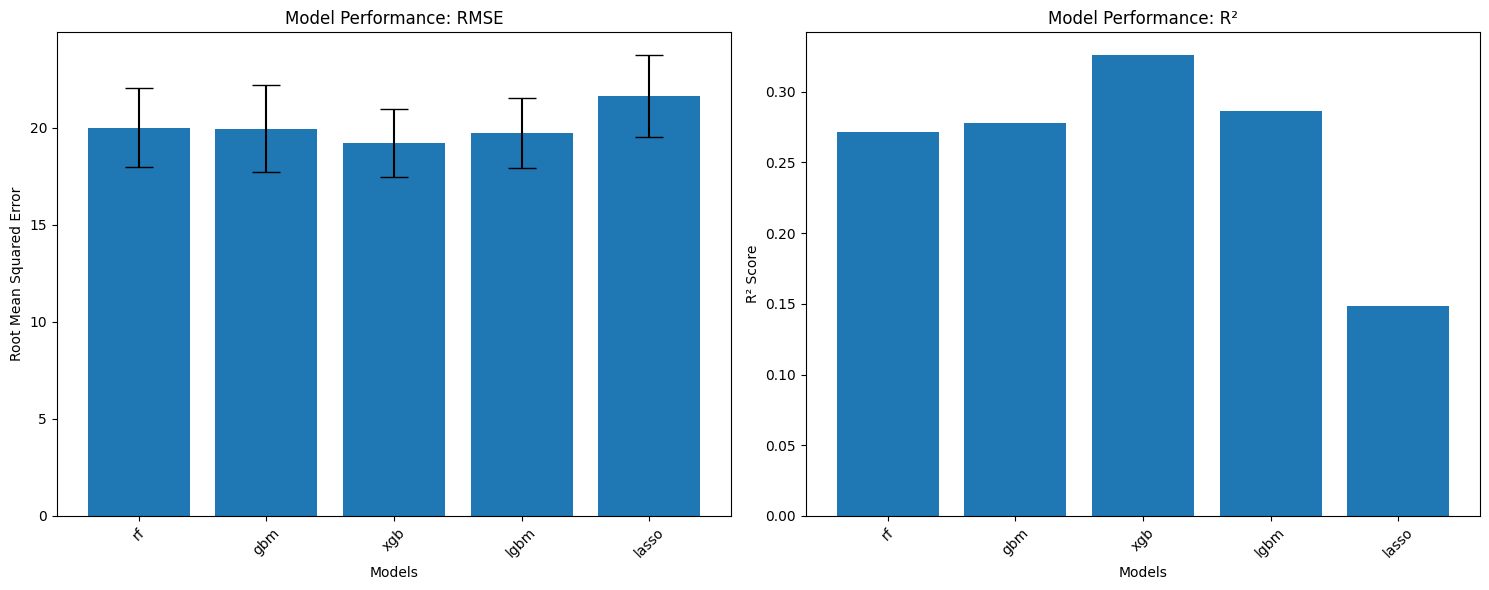

In [ ]:
# Performance Comparison Plot
plot_model_performance_comparison(model_pipeline)

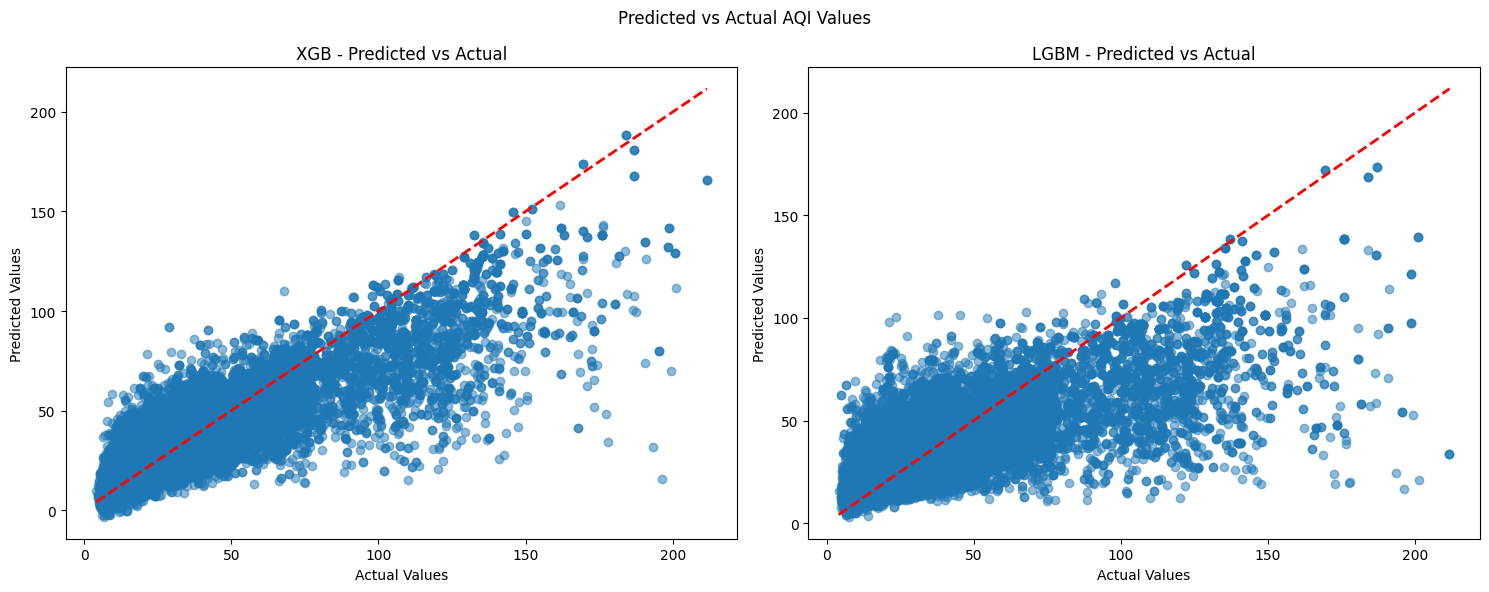

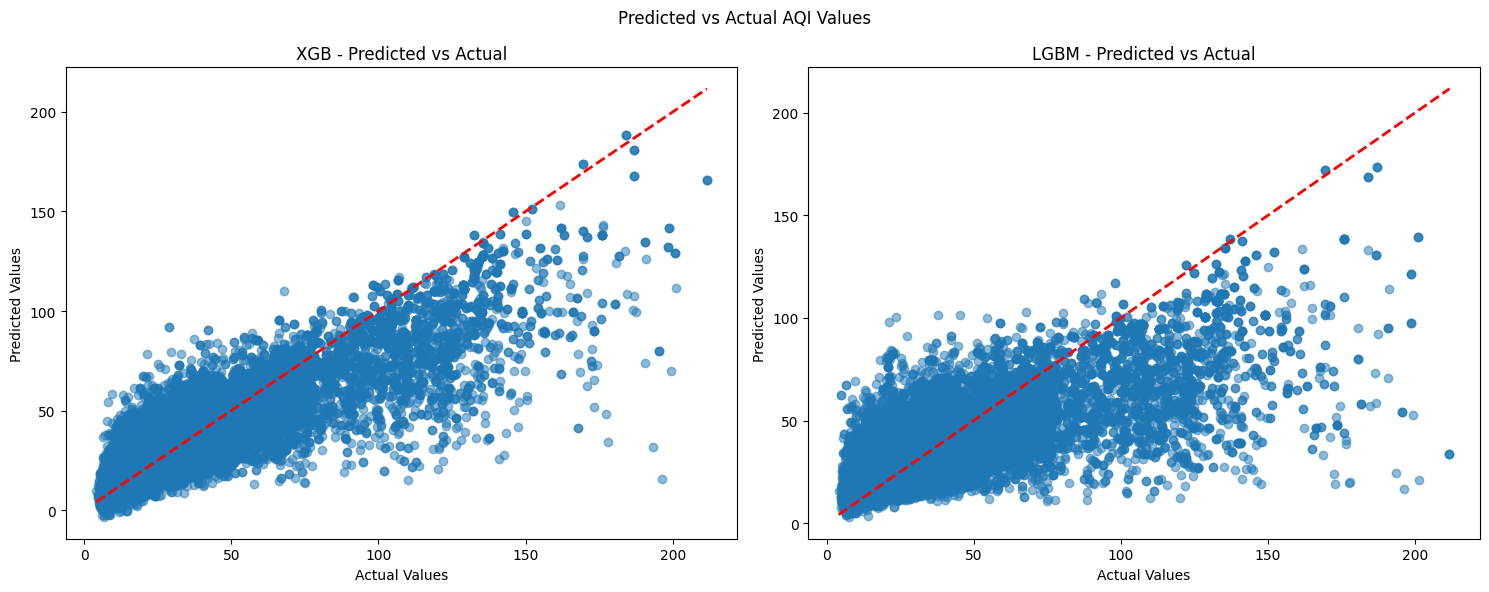

In [ ]:
# Predicted vs Actual AQI Values
plot_predicted_vs_actual(model_pipeline,X, y)

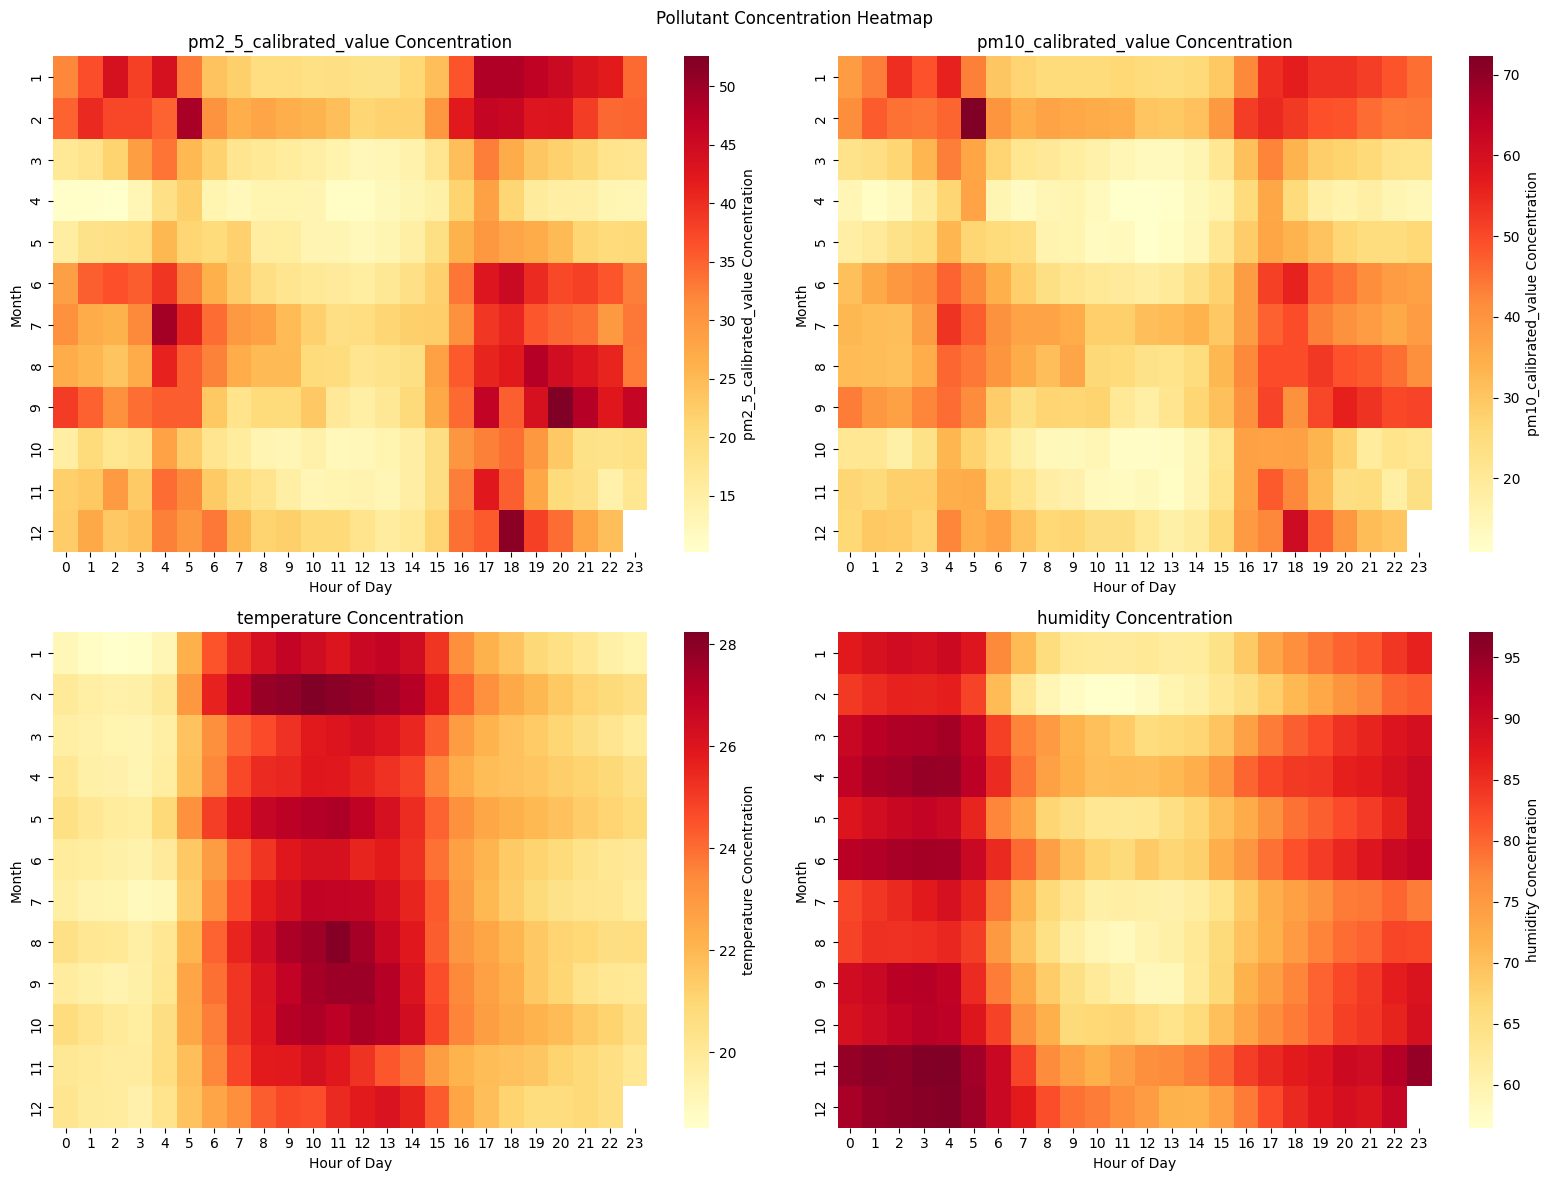

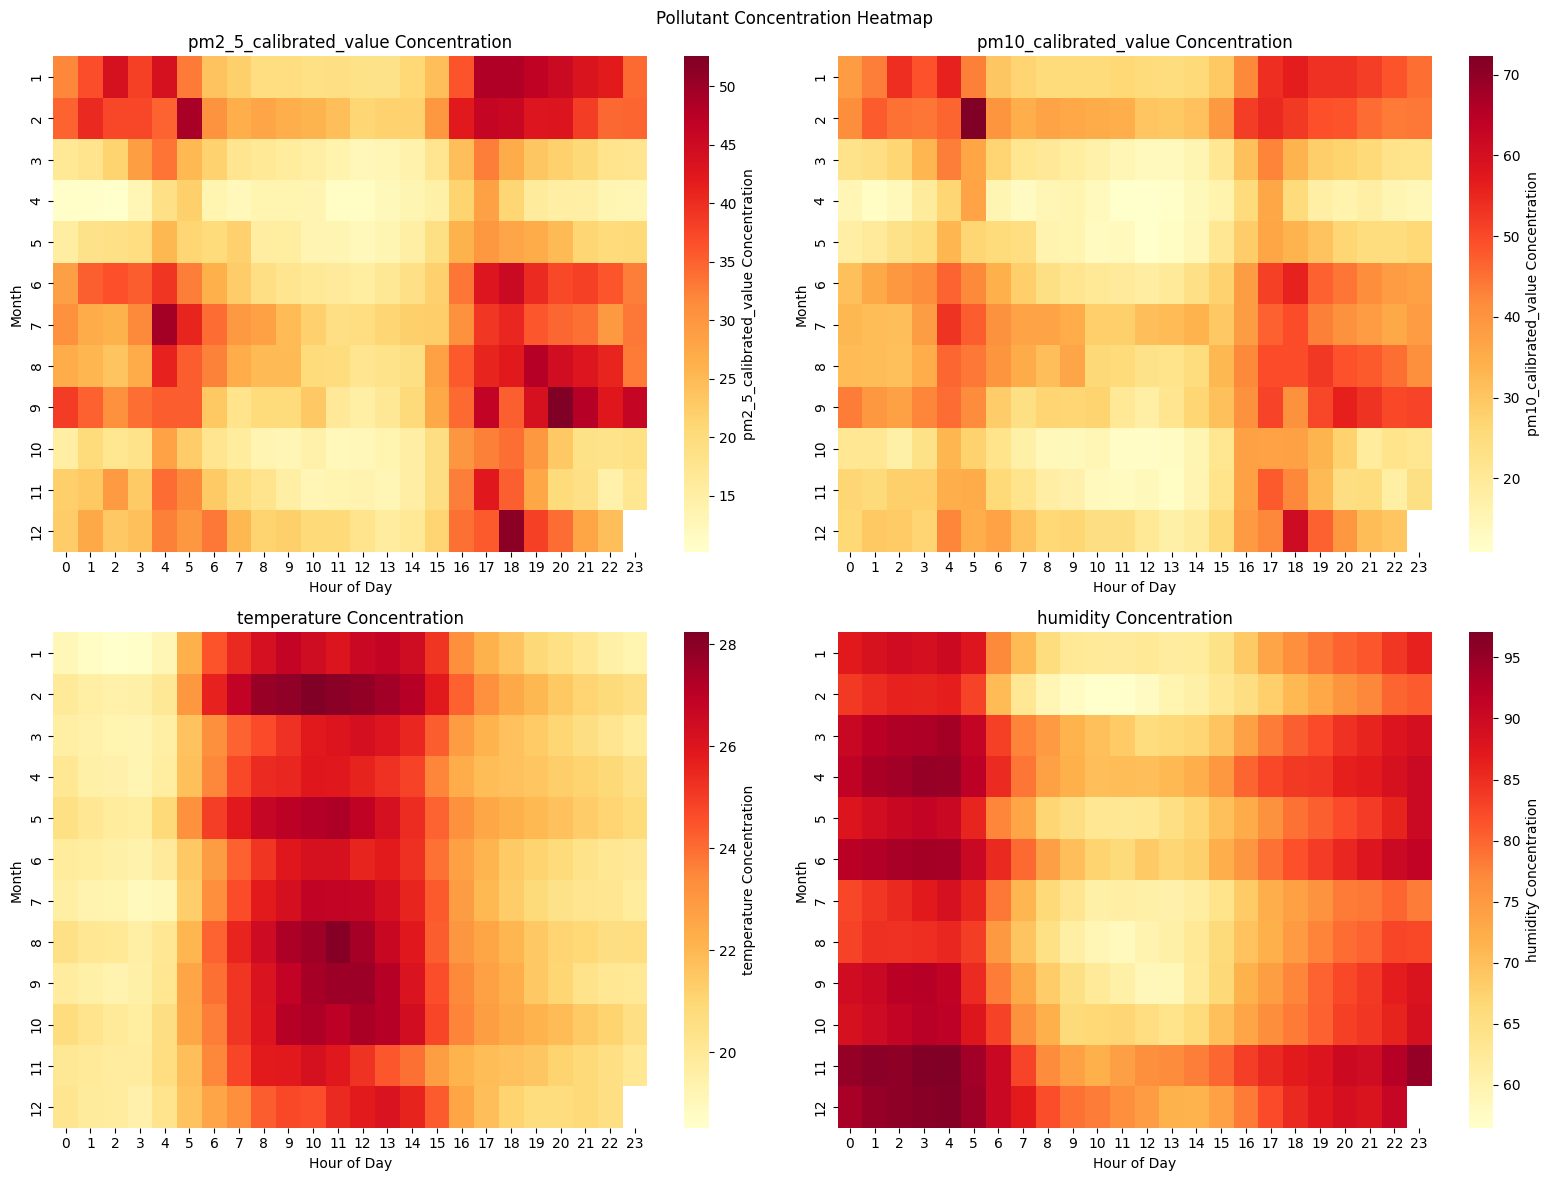

In [ ]:
# Pollutant Concentration Heatmap
plot_pollutant_concentration_heatmap(full_dataset)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

class AirQualityXAI:
    def __init__(self, model, X, y):
        """
        Initialize XAI analysis for air quality model

        Parameters:
        - model: Trained machine learning model
        - X: Feature matrix
        - y: Target variable
        """
        self.model = model
        self.X = X
        self.y = y

        # Split data for SHAP analysis
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    def shap_global_explanation(self, max_display=20):
        """
        Generate global SHAP (SHapley Additive exPlanations) feature importance

        Parameters:
        - max_display: Number of top features to display
        """
        # Use TreeExplainer for tree-based models
        if 'RandomForestRegressor' in str(type(self.model)) or \
           'XGBRegressor' in str(type(self.model)) or \
           'LGBMRegressor' in str(type(self.model)):
            explainer = shap.TreeExplainer(self.model)
        else:
            # Fallback to kernel explainer for other models
            explainer = shap.KernelExplainer(self.model.predict, self.X_train)

        # Compute SHAP values
        shap_values = explainer.shap_values(self.X_test)

        # Plot summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, self.X_test,
                          show=False,
                          max_display=max_display,
                          plot_type='bar')
        plt.title('Global Feature Importance (SHAP Values)')
        plt.tight_layout()
        plt.show()

        return shap_values

    def shap_dependence_plots(self, top_n=5):
        """
        Generate SHAP dependence plots for top features

        Parameters:
        - top_n: Number of top features to analyze
        """
        # Use TreeExplainer for tree-based models
        if 'RandomForestRegressor' in str(type(self.model)) or \
           'XGBRegressor' in str(type(self.model)) or \
           'LGBMRegressor' in str(type(self.model)):
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.KernelExplainer(self.model.predict, self.X_train)

        # Compute SHAP values
        shap_values = explainer.shap_values(self.X_test)

        # Get feature importance from SHAP values
        shap_importance = np.abs(shap_values).mean(axis=0)
        top_feature_indices = shap_importance.argsort()[-top_n:][::-1]

        # Create dependence plots
        plt.figure(figsize=(15, 3 * top_n))
        for i, feature_idx in enumerate(top_feature_indices):
            plt.subplot(top_n, 1, i+1)
            shap.dependence_plot(
                feature_idx,
                shap_values,
                self.X_test,
                show=False,
                interaction_index=None
            )
        plt.tight_layout()
        plt.show()

    def partial_dependence_analysis(self, top_n=5):
        """
        Generate Partial Dependence Plots to show the marginal effect of features

        Parameters:
        - top_n: Number of top features to analyze
        """
        # Identify top features (using feature importance if available)
        if hasattr(self.model, 'feature_importances_'):
            feature_importance = self.model.feature_importances_
            top_feature_indices = feature_importance.argsort()[-top_n:][::-1]
            top_features = self.X.columns[top_feature_indices]
        else:
            # Fallback to first n features if no feature importance available
            top_features = self.X.columns[:top_n]

        # Create partial dependence plots
        fig, ax = plt.subplots(1, len(top_features), figsize=(15, 4))
        for i, feature in enumerate(top_features):
            PartialDependenceDisplay.from_estimator(
                self.model,
                self.X,
                features=[feature],
                ax=ax[i] if len(top_features) > 1 else ax
            )

        plt.suptitle('Partial Dependence Plots')
        plt.tight_layout()
        plt.show()

    def local_interpretable_model_explanation(self):
        """
        Generate Local Interpretable Model-agnostic Explanations (LIME)
        for a few individual predictions
        """
        from lime import lime_tabular

        # Create LIME explainer
        explainer = lime_tabular.LimeTabularExplainer(
            self.X_train.values,
            feature_names=self.X.columns.tolist(),
            class_names=['PM2.5 Concentration'],
            verbose=False,
            mode='regression'
        )

        # Select a few random instances to explain
        np.random.seed(42)
        indices = np.random.choice(len(self.X_test), 3, replace=False)

        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(indices):
            # Get local explanation
            exp = explainer.explain_instance(
                self.X_test.values[idx],
                self.model.predict,
                num_features=5
            )

            # Plot local explanation
            plt.subplot(1, 3, i+1)
            exp.as_pyplot_figure()
            plt.title(f'Local Explanation for Instance {idx}')

        plt.tight_layout()
        plt.show()

    def run_all_xai_analyses(self):
        """
        Run all XAI analyses in sequence
        """
        print("Running Global SHAP Explanation...")
        self.shap_global_explanation()

        print("\nRunning SHAP Dependence Plots...")
        self.shap_dependence_plots()

        print("\nRunning Partial Dependence Analysis...")
        self.partial_dependence_analysis()

        try:
            print("\nRunning Local Interpretable Model Explanation...")
            self.local_interpretable_model_explanation()
        except ImportError:
            print("LIME not available. Skipping local explanation.")

# Modify AirQualityModelPipeline to include XAI method
def add_xai_method(cls):
    def xai_analysis(self, X, y):
        """
        Perform XAI analysis on the best model
        """
        if self.best_model is None:
            raise ValueError("Train the model first before performing XAI analysis")

        xai_analyzer = AirQualityXAI(self.best_model, X, y)
        xai_analyzer.run_all_xai_analyses()

    cls.xai_analysis = xai_analysis
    return cls

# Update the class
AirQualityModelPipeline = add_xai_method(AirQualityModelPipeline)

Running Global SHAP Explanation...


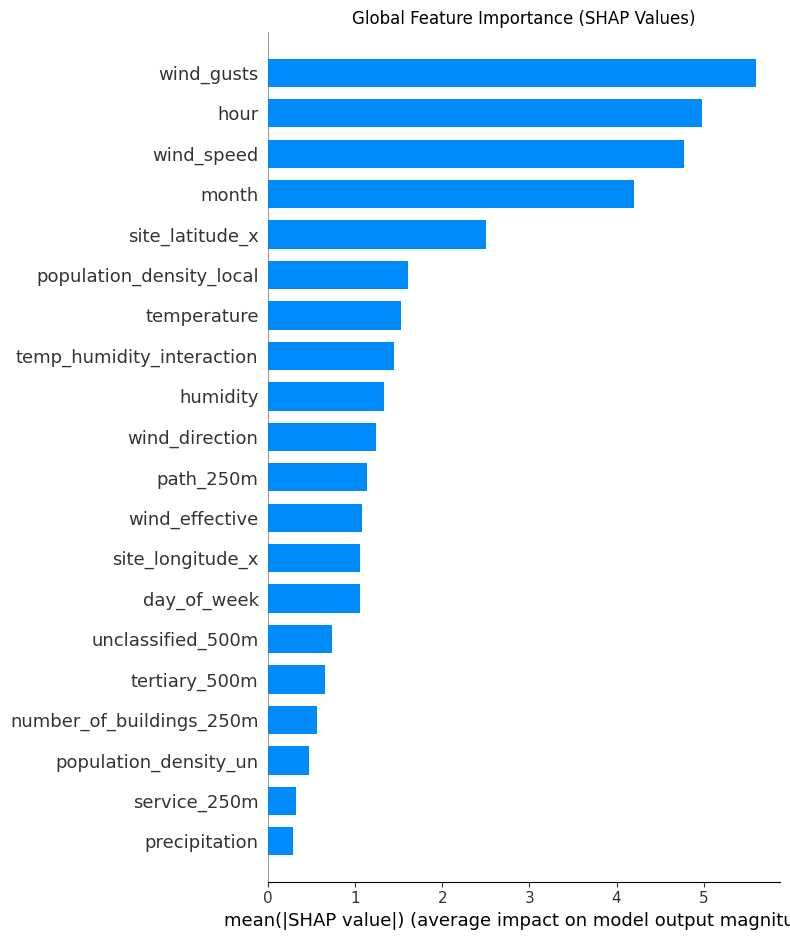


Running SHAP Dependence Plots...


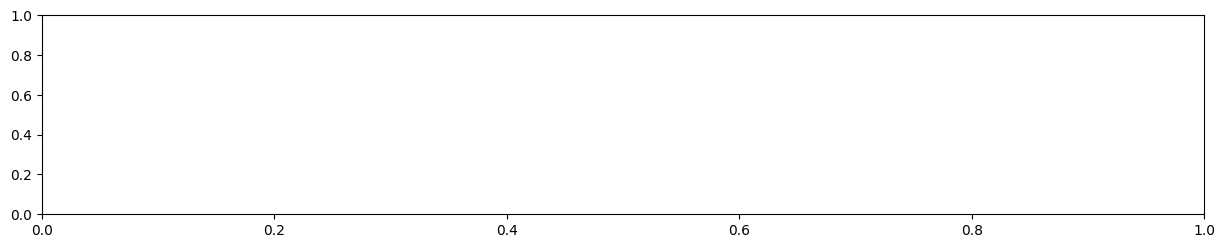

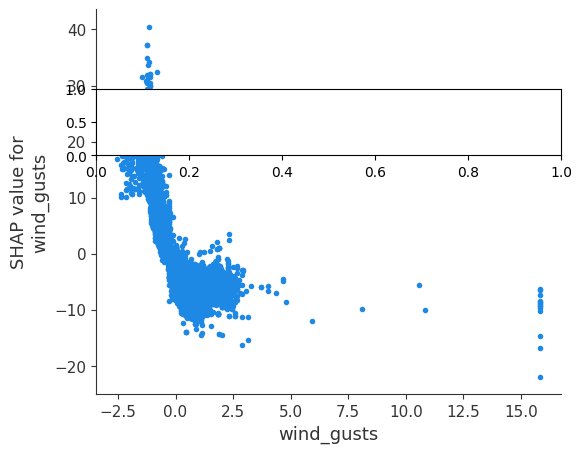

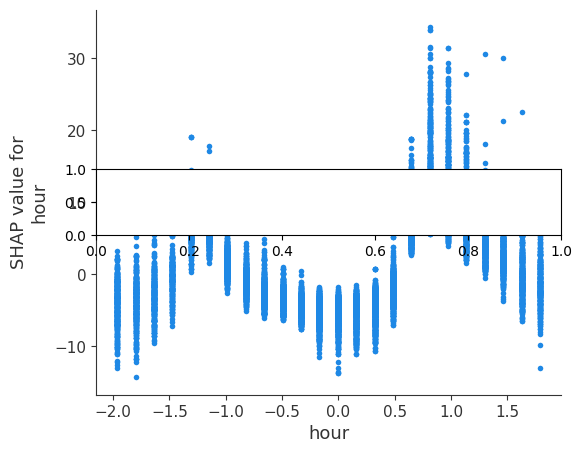

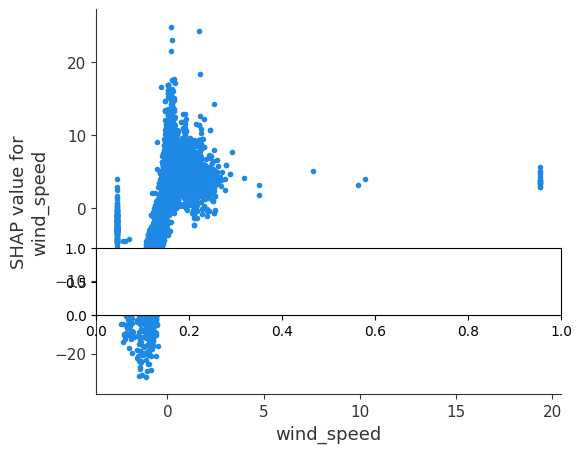

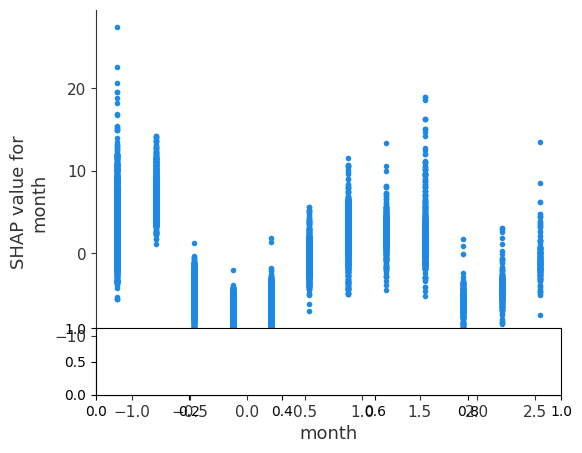

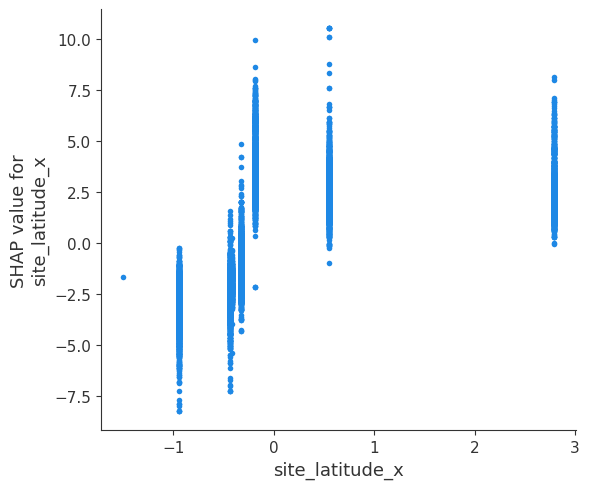


Running Partial Dependence Analysis...


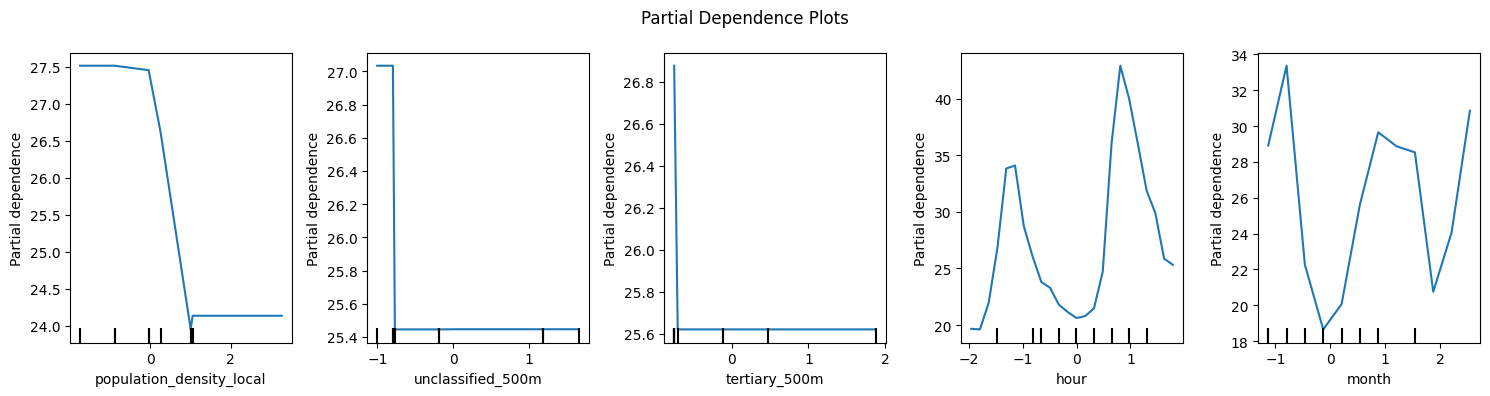


Running Local Interpretable Model Explanation...


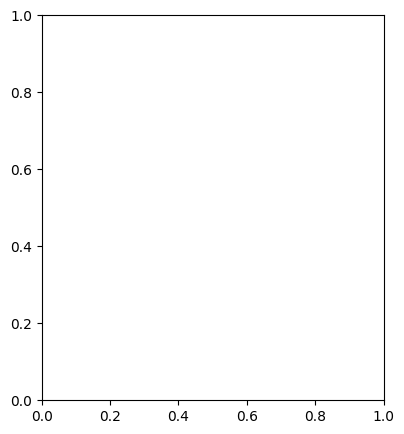

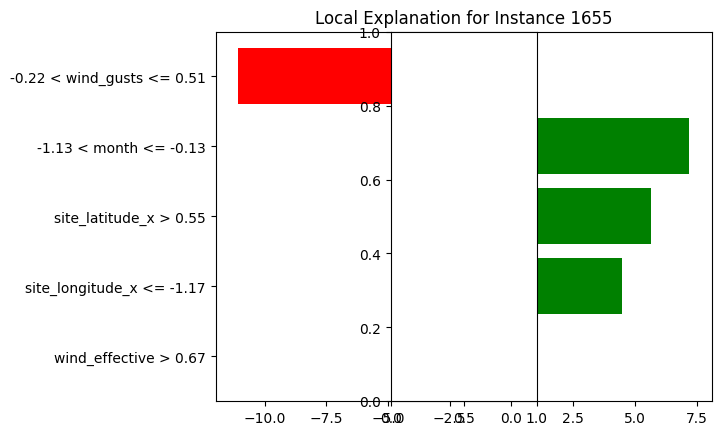

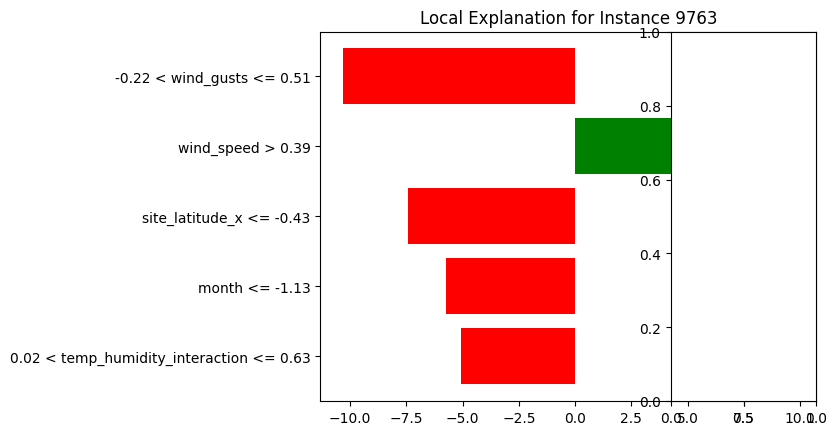

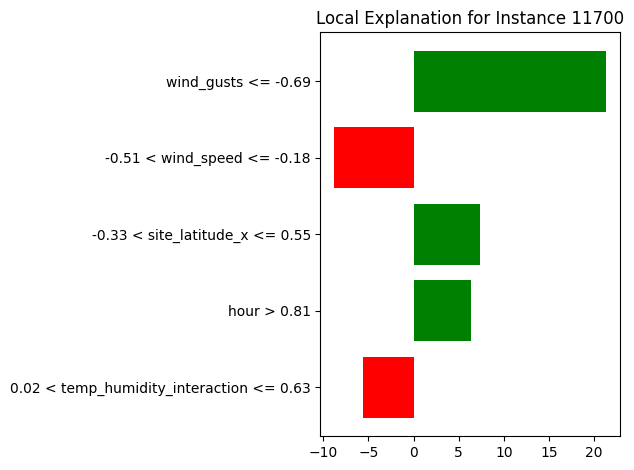

In [ ]:
# Perform XAI analysis
model_pipeline.xai_analysis(X, y)
